# 量化金融
- chatgpt5.2 自学量化金融
- 学习路线: 数学 + 编程 → 金融基础 → 量化模型 → 实盘与工程化
- 阶段一: 打地基
    - 数学: 概率论与统计,线性代数 
    - 编程: python
- 阶段二: 金融+量化基础
    - 金融市场基础: 期权、期货及其他衍生品
    - 经典量化策略: 均线策略(MA/EMA),动量策略,均值回归,因子投资(市值,价值,动量)
- 阶段三: 进阶量化
    - 回测与风险控制: 数据泄露,手续费&滑点,过拟合
    - 因子与组合
- 阶段四:工程化&实战
    - 工程能力
    - 模拟与实盘

## lesson 1: 量化金融的本质
> 量化金融 = 用统计方法，在不确定的世界里寻找“概率优势”
- 收益率
    - $r = (P_t - P_{t-1}) / P_{t-1}$
    - $log return = ln(P_t / P_{t-1})$
  
- 课程目标
    - 市场是一个概率系统,量化的目的是要找到长期收益为正的模型
    - 好策略 ≠ 每次赚钱,长期平滑且向上的收益
    - 稳定性 > 单次暴利

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 模拟价格
np.random.seed(42)
returns = np.random.normal(0.001, 0.01, 252)
price = 100 * (1 + returns).cumprod()
# 随机生成一组呈正态分布均值为0.001，标准差为0.01的收益率数据，并计算价格

df_lesson1 = pd.DataFrame({
    "price": price,
    "return": returns
})

print("平均收益:", df_lesson1["return"].mean())
print("波动率:", df_lesson1["return"].std())

平均收益: 0.000962351268346709
波动率: 0.009672153125430863


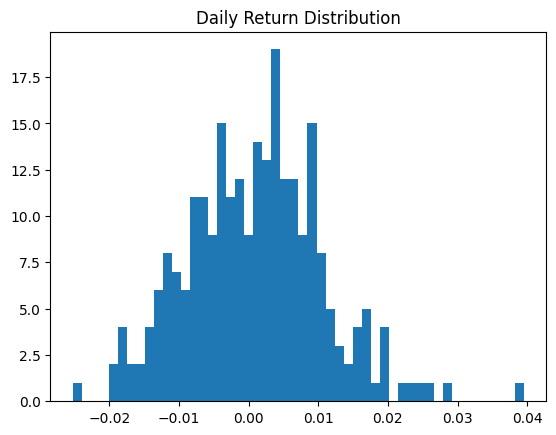

In [ ]:
plt.hist(df_lesson1["return"], bins=50)
plt.title("Daily Return Distribution")
plt.show()

## lesson 2: 先立规矩

- 交易铁律
    1. 不预测单日涨跌
    2. 不追求每天都有交易
    3. 不接受超过 30% 的最大回撤

- 回测陷阱
    1. 未来函数(最致命)
        - ❌ 错误示例：
            - 用当天收盘价决定当天是否买入
            - 用未来财报做历史选股
        - ✅ 正确做法：
            - 今天只能用昨天及以前的数据
            - 交易发生在下一根 K 线
        - 📌 判断标准：如果你的策略“反应特别快”，先怀疑它
    2. 幸存者偏差
        - ❌ 错误示例：
            - 用“现在还在的股票”回测 10 年
            - 忽略退市股
        - 📌 ETF 相对安全，但：
            - 行业 ETF 更容易踩坑
            - 指数成分历史也会变
    3. 过拟合（看起来像天才）
        - 典型症状：
            - 参数一改，收益暴涨
            - 策略只在历史某一段特别好
        - 📌 量化铁律：参数越少，活得越久
    4. 频繁交易,忽略交易成本
    5. 样本内 / 样本外混用
        - 70%历史训练,30%验证

### 实现一个简单的策略
- 策略核心结构
- 趋势过滤（是否值得参与）--> 入场信号（什么时候进）--> 仓位控制（进多少）--> 退出规则（什么时候走）
    1. 选择标的: 指数型etf
    2. 趋势过滤: 60日均线为生死线,收盘价 > MA60 → 允许交易;收盘价 ≤ MA60 → 空仓
    3. 入场信号: 昨日收盘价 > MA20,且处于 MA60 上方 → 下一交易日买入
    4. 退出规则（平滑关键）:昨日收盘价 < MA20 → 下一日清仓或跌破 MA60 → 无条件空仓
    5. 成本假设: 单边成本：0.1%, 换仓即扣

- 获取数据

In [34]:
import akshare as ak

# 获取 ETF 日线数据
df = ak.fund_etf_hist_em(
    symbol="510300",
    period="daily",
    start_date="20180101",
    end_date="20251231",
    adjust="qfq"
)

df = df.rename(columns={
    "日期": "date",
    "收盘": "close"
})

df["date"] = pd.to_datetime(df["date"])
df = df[["date", "close"]].sort_values("date").reset_index(drop=True)
print(df.head())

# df.to_csv("etf.csv", index=False)

        date  close
0 2018-01-02  3.478
1 2018-01-03  3.500
2 2018-01-04  3.513
3 2018-01-05  3.529
4 2018-01-08  3.546


- 模拟计算

年化收益: -1.46%
最大回撤: -34.43%
夏普比率: -0.04


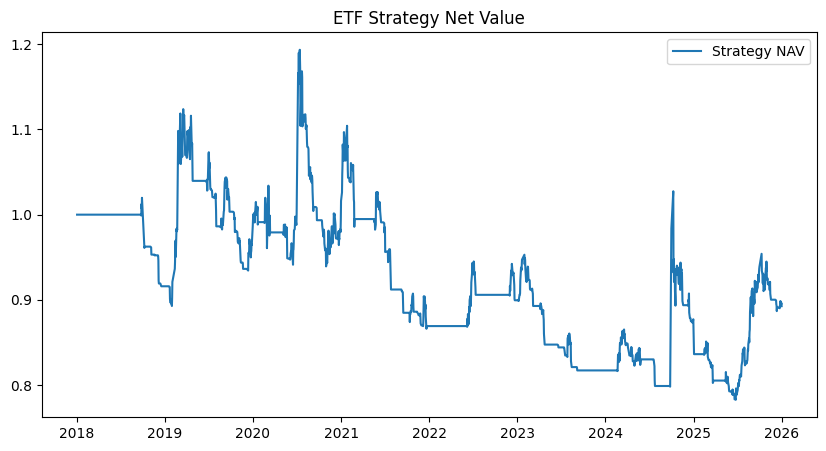

In [ ]:
# === 1. 读取数据 ===
# CSV 需要至少包含: date, close
df = pd.read_csv("etf.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# === 2. 计算指标 ===
df["MA20"] = df["close"].rolling(20).mean()
df["MA60"] = df["close"].rolling(60).mean()

# === 3. 生成信号（注意：信号用昨天的数据） ===
df["signal"] = 0

for i in range(1, len(df)):
    if df.loc[i-1, "close"] > df.loc[i-1, "MA20"] and df.loc[i-1, "close"] > df.loc[i-1, "MA60"]:
        df.loc[i, "signal"] = 1
    else:
        df.loc[i, "signal"] = 0

# === 4. 计算收益 ===
df["daily_return"] = df["close"].pct_change()
df["strategy_return"] = df["signal"].shift(1) * df["daily_return"]

# === 5. 加入交易成本 ===
df["trade"] = df["signal"].diff().abs()
df["strategy_return"] -= df["trade"] * 0.001

# === 6. 计算净值 ===
df["nav"] = (1 + df["strategy_return"].fillna(0)).cumprod()

# === 7. 绩效指标 ===
annual_return = df["nav"].iloc[-1] ** (252 / len(df)) - 1
max_drawdown = (df["nav"] / df["nav"].cummax() - 1).min()
sharpe = df["strategy_return"].mean() / df["strategy_return"].std() * np.sqrt(252)

print(f"年化收益: {annual_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharpe:.2f}")

# === 8. 画图 ===
plt.figure(figsize=(10,5))
plt.plot(df["date"], df["nav"], label="Strategy NAV")
plt.legend()
plt.title("ETF Strategy Net Value")
plt.show()